# PyQuant News Guide

In [1]:
%matplotlib inline

import time
import datetime as dt
from math import sqrt, pi

import numpy as np
import pandas as pd
from pandas_datareader.yahoo.options import Options
from pandas_datareader.yahoo.daily import YahooDailyReader
import matplotlib as mat

mat.style.use("ggplot")
import matplotlib.pyplot as plt

# for plotting the vol surface
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import interp1d

print(f"Numpy {np.__version__}\nMatplotlib {mat.__version__}\nScipy {scipy.__version__}\nPandas {pd.__version__}")

Numpy 1.20.3
Matplotlib 3.4.2
Scipy 1.7.1
Pandas 1.3.2


In [3]:
# underlying stock price
S = 45.0

# series of underlying stock prices to demonstrate a payoff profile
S_ = np.arange(35.0, 55.0, 0.01)

# strike price
K = 45.0

# time to expiration (this will be a T-t in the equation)
t = 164.0 / 365.0

# risk free rate
r = 0.02

# volatility
vol = 0.25

# black scholes prices for demonstrating trades
atm_call_premium = 3.20
atm_put_premium = 2.79

otm_call_premium = 1.39
otm_put_premium = 0.92

# payoff functions

# equivalent to:
# def call_payoff(S, K):
#     return np.maximum(S - K, 0.0)
call_payoff = lambda S, K: np.maximum(S_ - K, 0.0)

# equivalent to:
# def put_payoff(S, K):
#     return np.maximum(K - S, 0.0)
put_payoff = lambda S, K: np.maximum(K - S_, 0.0)

Plot the call payoff

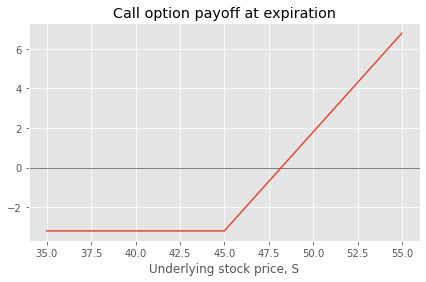

In [5]:
plt.figure(1, figsize=(7,4))
plt.title("Call option payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, -atm_call_premium + call_payoff(S_, K))

Plot the put payoff

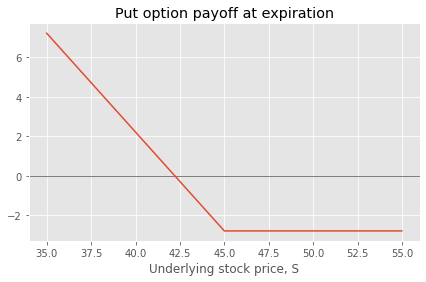

In [6]:
plt.figure(2, figsize=(7,4))
plt.title("Put option payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, -atm_put_premium + put_payoff(S_, K))

Plot a long straddle payoff

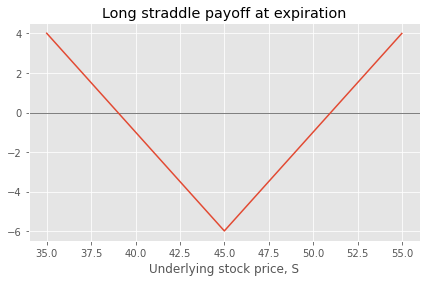

In [7]:
long_straddle = call_payoff(S_, K) + put_payoff(S_, K)
long_straddle_premium = -atm_call_premium - atm_put_premium
plt.figure(3, figsize=(7,4))
plt.title("Long straddle payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, long_straddle_premium + long_straddle)

Plot a short straddle payoff

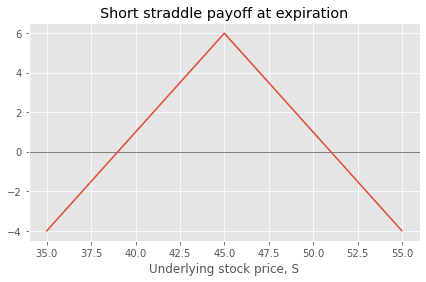

In [8]:
short_straddle = -call_payoff(S_, K) - put_payoff(S_, K)
short_straddle_premium = atm_call_premium + atm_put_premium
plt.figure(4, figsize=(7,4))
plt.title("Short straddle payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, short_straddle_premium - long_straddle)

Plot a short iron condor payoff

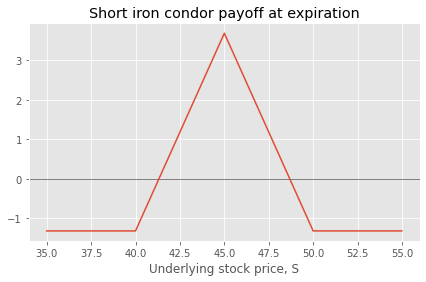

In [9]:
short_iron_condor = (
    call_payoff(S_, K + 5)
    - call_payoff(S_, K)
    - put_payoff(S_, K)
    + put_payoff(S_, K - 5)
)
short_iron_condor_premium = (
    -otm_call_premium + atm_call_premium + atm_put_premium - otm_put_premium
)
plt.figure(5, figsize=(7,4))
plt.title("Short iron condor payoff at expiration")
plt.xlabel("Underlying stock price, S")
plt.axhline(y=0, lw=1, c="grey")
plt.plot(S_, short_iron_condor_premium + short_iron_condor)

Black-Scholes Formula in Python

In [10]:
def N(z):
    """ Normal cumulative density function

    :param z: point at which cumulative density is calculated 
    :return: cumulative density under normal curve
    """
    return norm.cdf(z)


def black_scholes_call_value(S, K, r, t, vol):
    """ Black-Scholes call option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS call option value
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    return N(d1) * S - N(d2) * K * np.exp(-r * t)


def black_scholes_put_value(S, K, r, t, vol):
    """ Black-Scholes put option

    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: BS put option value
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    return N(-d2) * K * np.exp(-r * t) - N(-d1) * S

In [11]:
call_value = black_scholes_call_value(S, K, r, t, vol)
put_value = black_scholes_put_value(S, K, r, t, vol)

print(f"Black-Scholes call value {call_value:.2f}")
print(f"Black-Scholes put value {put_value:.2f}")

Black-Scholes call value 3.20
Black-Scholes put value 2.79


In [12]:
# get the value of the option with six months to expiration
black_scholes_call_value_six_months = (
    black_scholes_call_value(S_, K, r, 0.5, vol) - atm_call_premium
)

# get the value of the option with three months to expiration
black_scholes_call_value_three_months = (
    black_scholes_call_value(S_, K, r, 0.25, vol) - atm_call_premium
)

# get the value of the option with one month to expiration
black_scholes_call_value_one_month = (
    black_scholes_call_value(S_, K, r, 1.0 / 12.0, vol) - atm_call_premium
)

# get payoff value at expiration
call_payoff_at_expiration = call_payoff(S_, K) - atm_call_premium

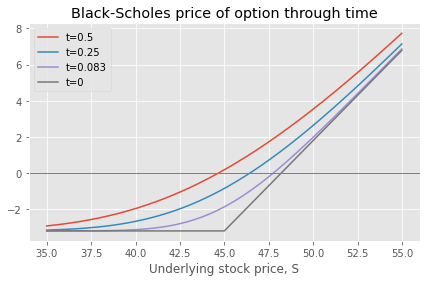

In [13]:
# plot the call payoffs
plt.figure(3, figsize=(7, 4))
plt.plot(S_, black_scholes_call_value_six_months)
plt.plot(S_, black_scholes_call_value_three_months)
plt.plot(S_, black_scholes_call_value_one_month)
plt.plot(S_, call_payoff_at_expiration)
plt.axhline(y=0, lw=1, c="grey")
plt.title("Black-Scholes price of option through time")
plt.xlabel("Underlying stock price, S")
plt.legend(["t=0.5", "t=0.25", "t=0.083", "t=0"], loc=2)

The Greeks in Python

In [14]:
# helper function phi
def phi(x):
    """ Phi helper function
    
    """
    return np.exp(-0.5 * x * x) / (sqrt(2.0 * pi))


# shared
def gamma(S, K, r, t, vol):
    """ Black-Scholes gamma
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: gamma
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return phi(d1) / (S * vol * sqrt(t))


def vega(S, K, r, t, vol):
    """ Black-Scholes vega
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: vega
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return (S * phi(d1) * sqrt(t)) / 100.0


# call options
def call_delta(S, K, r, t, vol):
    """ Black-Scholes call delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call delta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return N(d1)

In [15]:
def call_theta(S, K, r, t, vol):
    """ Black-Scholes call theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call theta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) - (
        r * K * np.exp(-r * t) * N(d2)
    )
    return theta / 365.0


def call_rho(S, K, r, t, vol):
    """ Black-Scholes call rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: call rho
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    rho = K * t * np.exp(-r * t) * N(d2)
    return rho / 100.0


# put options
def put_delta(S, K, r, t, vol):
    """ Black-Scholes put delta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put delta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)

    return N(d1) - 1.0

In [16]:
def put_theta(S, K, r, t, vol):
    """ Black-Scholes put theta
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put theta
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    theta = -((S * phi(d1) * vol) / (2.0 * np.sqrt(t))) + (
        r * K * np.exp(-r * t) * N(-d2)
    )
    return theta / 365.0


def put_rho(S, K, r, t, vol):
    """ Black-Scholes put rho
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: put rho
    """
    d1 = (1.0 / (vol * np.sqrt(t))) * (np.log(S / K) + (r + 0.5 * vol ** 2.0) * t)
    d2 = d1 - (vol * np.sqrt(t))

    rho = -K * t * np.exp(-r * t) * N(-d2)
    return rho / 100.0

In [17]:
# print each of the results
print("Black-Scholes call delta %0.4f" % call_delta(S, K, r, t, vol))
print("Black-Scholes put delta %0.4f" % put_delta(S, K, r, t, vol))
print("Black-Scholes gamma %0.4f" % gamma(S, K, r, t, vol))
print("Black-Scholes vega %0.4f" % vega(S, K, r, t, vol))
print("Black-Scholes call theta %0.4f" % call_theta(S, K, r, t, vol))
print("Black-Scholes put theta %0.4f" % put_theta(S, K, r, t, vol))
print("Black-Scholes call rho %0.4f" % call_rho(S, K, r, t, vol))
print("Black-Scholes put rho %0.4f" % put_rho(S, K, r, t, vol))

Black-Scholes call delta 0.5546
Black-Scholes put delta -0.4454
Black-Scholes gamma 0.0524
Black-Scholes vega 0.1192
Black-Scholes call theta -0.0103
Black-Scholes put theta -0.0078
Black-Scholes call rho 0.0978
Black-Scholes put rho -0.1026


Realized Volatility

In [18]:
# define a stock symbol
underlying_symbol = "IBM"

# define a YahooDailyReader object
price_obj = YahooDailyReader(underlying_symbol, start="2015-01-01", end="2015-12-31")

# request historical data
prices = price_obj.read()

# yahoo returns prices in ascending order, sort to descending order
prices.sort_index(ascending=False, inplace=True)

# let's pickle the dataframe so we don't have to hit the network every time
prices.to_pickle("underlying_prices.pickle")

In [19]:
# read the original frame in from cache (pickle)
prices = pd.read_pickle("underlying_prices.pickle")

<AxesSubplot:xlabel='Date'>

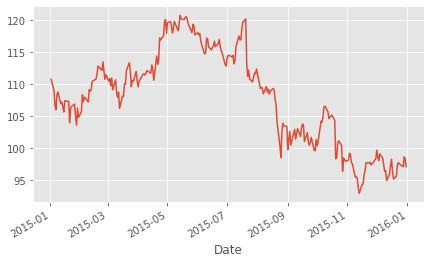

In [21]:
prices["Adj Close"].plot(figsize=(7, 4))

Use the last month (roughly 22 trading days) of the data set to compute 

In [22]:
# compute the log returns from the adjusted closing price
log_return = (prices["Adj Close"] / prices["Adj Close"].shift(-1)).apply(np.log)

# take the standard deviation of the last month of data (22 trading days)
sd_of_log_returns = log_return.head(22).std()

# multiply by the square root of the number of trading days in a year (252) to annualize
realized_volatility = sd_of_log_returns * sqrt(252)

In [23]:
print("One month, annualized realized volatility %0.4f" % realized_volatility)

One month, annualized realized volatility 0.1798


In [24]:
# use the pandas DataFrame.rolling method to create a rolling standard deviation of 
# log returns, then multiply by square root of 252 to annualize
rolling_realized_volatility = log_return.rolling(window=22, center=False).std() * sqrt(
    252
)

<AxesSubplot:title={'center':'Historic one month, annualized realized volatility'}, xlabel='Date'>

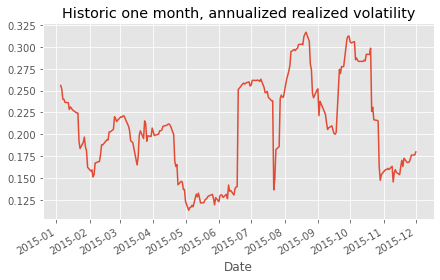

In [25]:
# note that we plot plot directly from a pandas data frame!
rolling_realized_volatility.plot(
    title="Historic one month, annualized realized volatility", figsize=(7, 4)
)

Implied Volatility

In [26]:
def call_implied_volatility_objective_function(
    S, K, r, t, vol, call_option_market_price
):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return call_option_market_price - black_scholes_call_value(S, K, r, t, vol)

In [27]:
def call_implied_volatility(
    S, K, r, t, call_option_market_price, a=-2.0, b=2.0, xtol=1e-6
):
    """ Call implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """
    # avoid mirroring outer scope
    _S, _K, _r, _t, _call_option_market_price = S, K, r, t, call_option_market_price

    # define a nested function that takes our target param as the input
    def fcn(vol):

        # returns the difference between market and model price at given volatility
        return call_implied_volatility_objective_function(
            _S, _K, _r, _t, vol, _call_option_market_price
        )

    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)

        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result

    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

    
def put_implied_volatility_objective_function(S, K, r, t, vol, put_option_market_price):
    """ Objective function which sets market and model prices to zero
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :param call_option_market_price: market observed option price
    :return: error between market and model price
    """
    return put_option_market_price - black_scholes_put_value(S, K, r, t, vol)

In [28]:
def put_implied_volatility(
    S, K, r, t, put_option_market_price, a=-2.0, b=2.0, xtol=1e-6
):
    """ Put implied volatility function
    
    :param S: underlying
    :param K: strike price
    :param r: rate
    :param t: time to expiration
    :param call_option_market_price: market observed option price
    :param a: lower bound for brentq method
    :param b: upper gound for brentq method
    :param xtol: tolerance which is considered good enough
    :return: volatility to sets the difference between market and model price to zero
    
    """

    # avoid mirroring out scope
    _S, _K, _r, _t, _put_option_market_price = S, K, r, t, put_option_market_price

    # define a nsted function that takes our target param as the input
    def fcn(vol):

        # returns the difference between market and model price at given volatility
        return put_implied_volatility_objective_function(
            _S, _K, _r, _t, vol, _put_option_market_price
        )

    # first we try to return the results from the brentq algorithm
    try:
        result = brentq(fcn, a=a, b=b, xtol=xtol)

        # if the results are *too* small, sent to np.nan so we can later interpolate
        return np.nan if result <= 1.0e-6 else result

    # if it fails then we return np.nan so we can later interpolate the results
    except ValueError:
        return np.nan

In [29]:
# get the call and put values to test the implied volatility output
call_model_price = black_scholes_call_value(S, K, r, t, vol)
print(
    "Call implied volatility if market and model were equal (should be close to 0.25) %0.6f"
    % call_implied_volatility(S, K, r, t, call_model_price)
)

put_model_price = black_scholes_put_value(S, K, r, t, vol)
print(
    "Put implied volatility if market and model were equal (should be close to 0.25) %0.6f"
    % put_implied_volatility(S, K, r, t, put_model_price)
)

Call implied volatility if market and model were equal (should be close to 0.25) 0.250000
Put implied volatility if market and model were equal (should be close to 0.25) 0.250000


Getting Real Options Market Data

In [30]:
# define a stock symbol
underlying_symbol = "IBM"

# # define a Options object
# options_obj = Options('IBM')

# # request all chains for the underlying symbol
# options_frame_live = options_obj.get_all_data()

# let's pickle the dataframe so we don't have to hit the network every time
# options_frame_live.to_pickle('options_frame.pickle')

In [32]:
# read the original frame in from cache (pickle)
options_frame = pd.read_pickle("./Inputs/options_frame.pickle")

In [33]:
# take a quick look at the DataFrame that returned
options_frame.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 519 entries, (70.0, Timestamp('2016-07-15 00:00:00'), 'put', 'IBM160715P00070000') to (280.0, Timestamp('2017-01-20 00:00:00'), 'put', 'IBM170120P00280000')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Last              519 non-null    float64       
 1   Bid               519 non-null    float64       
 2   Ask               519 non-null    float64       
 3   Chg               519 non-null    float64       
 4   PctChg            519 non-null    object        
 5   Vol               519 non-null    int64         
 6   Open_Int          519 non-null    int64         
 7   IV                519 non-null    object        
 8   Root              519 non-null    object        
 9   IsNonstandard     519 non-null    bool          
 10  Underlying        519 non-null    object        
 11  Underlying_Price  519 non-null    float64       
 12 

In [34]:
# and the first ten records
options_frame.head()

Last    Bid    Ask   Chg  PctChg  \
Strike Expiry     Type Symbol                                                  
70.0   2016-07-15 put  IBM160715P00070000   0.30   0.21   0.35  0.08  36.36%   
       2017-01-20 put  IBM170120P00070000   1.30   0.97   1.40  0.55  73.33%   
       2018-01-19 call IBM180119C00070000  63.00  57.50  62.50  0.00   0.00%   
                  put  IBM180119P00070000   2.30   0.96   2.50  0.32  16.16%   
75.0   2016-07-15 put  IBM160715P00075000   0.41   0.30   0.45  0.01   2.50%   

                                           Vol  Open_Int      IV Root  \
Strike Expiry     Type Symbol                                           
70.0   2016-07-15 put  IBM160715P00070000   15        10  46.63%  IBM   
       2017-01-20 put  IBM170120P00070000   48       118  43.12%  IBM   
       2018-01-19 call IBM180119C00070000   15         4  35.44%  IBM   
                  put  IBM180119P00070000    2        97  35.62%  IBM   
75.0   2016-07-15 put  IBM160715P00075000  166         3  43.95%  IBM   

                                           IsNonstandard Underlying  \
Strike Expiry     Type Symbol                                         
70.0   2016-07-15 put  IBM160715P00070000          False        IBM   
       2017-01-20 put  IBM170120P00070000          False        IBM   
       2018-01-19 call IBM180119C00070000          False        IBM   
                  put  IBM180119P00070000          False        IBM   
75.0   2016-07-15 put  IBM160715P00075000          False        IBM   

                                           Underlying_Price  \
Strike Expiry     Type Symbol                                 
70.0   2016-07-15 put  IBM160715P00070000            130.03   
       2017-01-20 put  IBM170120P00070000            130.03   
       2018-01-19 call IBM180119C00070000            130.03   
                  put  IBM180119P00070000            130.03   
75.0   2016-07-15 put  IBM160715P00075000            130.03   

                                                   Quote_Time  
Strike Expiry     Type Symbol                                  
70.0   2016-07-15 put  IBM160715P00070000 2016-01-18 16:03:00  
       2017-01-20 put  IBM170120P00070000 2016-01-18 16:03:00  
       2018-01-19 call IBM180119C00070000 2016-01-18 16:03:00  
                  put  IBM180119P00070000 2016-01-18 16:03:00  
75.0   2016-07-15 put  IBM160715P00075000 2016-01-18 16:03:00